In [244]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [245]:
def f1(x1,y1):
    return (x1**2+y1-11)**2+(x1+y1**2-7)**2
def f2(x2,y2):
    return 2*x2**2+1.05*x2**4+(x2**6)/6+x2*y2+y2**2

def sumF1F2(individual):
    x1,y1,x2,y2 = individual
    return f1(x1,y1)+f2(x2,y2)

In [246]:
def getPlotVariables(minVariable, maxVariable, function):
    x = np.linspace(minVariable, maxVariable, 100)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)
    return X, Y, Z

In [247]:
def draw2DPlot(X,Y,Z,bestPoint=None, additionalPoints=None):

    plt.contourf(X,Y,Z, levels=20, colors='white')
    contour = plt.contour(X,Y,Z, levels=10, colors='black')
    plt.clabel(contour, inline=1, fontsize=8)

    if bestPoint is not None:
        plt.plot(bestPoint[0], bestPoint[1], 'ro')
    if additionalPoints is not None:
        plt.scatter(additionalPoints[:,0], additionalPoints[:,1],marker='.',s=30)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

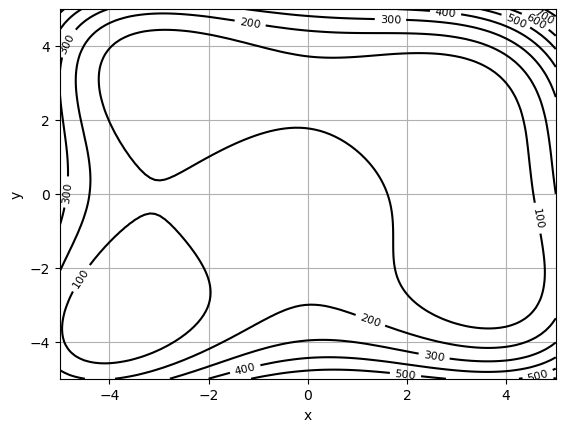

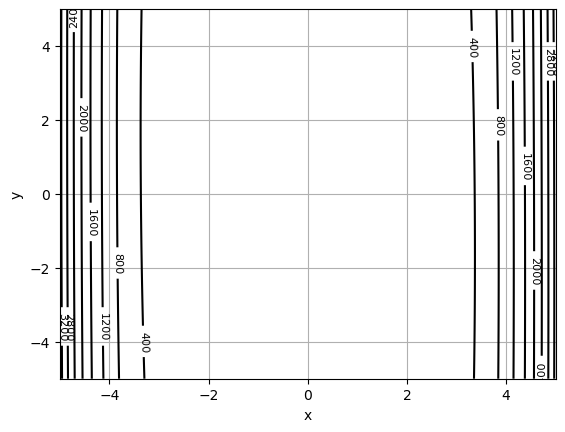

In [248]:
X1,Y1,Z1 = getPlotVariables(-5,5,f1)
draw2DPlot(X1,Y1,Z1)


X2,Y2,Z2 = getPlotVariables(-5,5,f2)
draw2DPlot(X2,Y2,Z2)

In [249]:
def gaussMutation(individual, sigma):
    mutatedIndividual = np.zeros(len(individual))
    for i in range(len(individual)):
        mutatedIndividual[i] = individual[i] + np.random.normal(0, sigma)
    return mutatedIndividual


In [250]:
def mutatePopulation(population, sigma):
    mutatedPopulation = []
    for individual in population:
        individual1 = gaussMutation(individual, sigma)
        mutatedPopulation.append(individual1)
    return mutatedPopulation

In [251]:
def individualSinglePointCrossBreeding(individual1, individual2):
    point = random.randint(0, len(individual1)-1)
    return np.concatenate((individual1[:point], individual2[point:]), axis=None)

In [252]:
def populationCrossBreeding(population, crossingProbability):
    random.shuffle(population)
    crossedPopulation = []
    for i in range(0, len(population), 2):
        if random.random() < crossingProbability:
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i], population[i+1]))
            crossedPopulation.append(individualSinglePointCrossBreeding(population[i+1], population[i]))
        else:
            crossedPopulation.append(population[i])
            crossedPopulation.append(population[i+1])
    return crossedPopulation

In [253]:
def generateRandomPopulation(size, D):
    return [np.random.uniform(D[0], D[1], 4) for _ in range(size)]


In [254]:
def isOutOfRange(individual, D):
    return individual[0] <= D[0] or individual[0] >= D[1] or individual[1] <= D[0] or individual[1] >= D[1] or individual[2] <= D[0] or individual[2] >= D[1] or individual[3] <= D[0] or individual[3] >= D[1]

In [255]:
def gradeIndividual(individual, D, gradingFunction):
    # if isOutOfRange(individual, D):
    #     # return 99999 * D[1] - np.absolute(sumF1F2(individual))
    #     return 1000
    return gradingFunction(individual)

In [256]:
def gradePopulation(population,D,gradingFunction):
    sum = 0
    for individual in population:
        sum += gradeIndividual(individual,D,gradingFunction)
    return sum

In [257]:
def tournamentSelection(population,D, gradingFunction):
    populationAfterSelection = []

    for _ in range(len(population)):
        individual1 = random.choice(population)
        individual2 = random.choice(population)
        if gradeIndividual(individual1,D,gradingFunction) < gradeIndividual(individual2,D,gradingFunction):
            populationAfterSelection.append(individual1)
        else:
            populationAfterSelection.append(individual2)
    return populationAfterSelection


In [258]:
def bringIndividualToBoundres(individual, D):
    for i in range(len(individual)):
        individual[i] = max(D[0], min(D[1], individual[i]))
    return individual

In [259]:
def bringPopulationToBoundries(population, D):
    for individual in population:
        individual = bringIndividualToBoundres(individual,D)
    return population

In [260]:
def updateBestIndividual(population, lastBestIndividual,D,gradingFunction):
    bestIndividual = lastBestIndividual
    bestValue = gradeIndividual(lastBestIndividual,D,gradingFunction)
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < bestValue:
            bestIndividual = individual
            bestValue = gradeIndividual(individual,D,gradingFunction)
    return bestIndividual


In [261]:
def findBestIndividual(population,D,gradingFunction):
    best = population[0]
    for individual in population:
        if gradeIndividual(individual,D,gradingFunction) < gradeIndividual(best,D,gradingFunction):
            best = individual
    return best

In [262]:
def generateValuesAroundPoint(size, point,sigma):
    return np.random.normal(point, sigma, (size, 2))

In [263]:
def generateSpecificF1Population(size, point, sigma, D):
    population = generateValuesAroundPoint(size, point, sigma)
    x2 = np.random.uniform(D[0], D[1], size)
    y2 = np.random.uniform(D[0], D[1], size)
    population = np.concatenate((population, np.array([x2,y2]).T), axis=1)
    population= bringPopulationToBoundries(population, D)
    return population

In [264]:
def evolutionAlgorithm(maxIterations,populationSize,crossingProbability,sigma,D,startingPopulation=None,gradingFunction=sumF1F2):
    epochs = []
    if startingPopulation is None:
        lastPopulation = generateRandomPopulation(populationSize, D)
    else:
        lastPopulation = bringPopulationToBoundries(startingPopulation,D)
    bestIndividual = updateBestIndividual(lastPopulation, lastPopulation[0],D,gradingFunction)
    lastPopulationGrade = gradePopulation(lastPopulation,D,gradingFunction)
    i = 0
    epochs.append(lastPopulation)
    while i < maxIterations:
        newPopulation = tournamentSelection(lastPopulation,D,gradingFunction)
        newPopulation = populationCrossBreeding(newPopulation, crossingProbability)
        newPopulation = mutatePopulation(newPopulation, sigma)
        newPopulation = bringPopulationToBoundries(newPopulation,D)
        bestIndividual = updateBestIndividual(newPopulation, bestIndividual, D,gradingFunction)
        newPopulationGrade = gradePopulation(newPopulation,D,gradingFunction)
        if newPopulationGrade < lastPopulationGrade:
            lastPopulation = newPopulation
            lastPopulationGrade = newPopulationGrade
        epochs.append(lastPopulation)
        i += 1
    return epochs, bestIndividual

In [265]:
# def evolutionAlgorithm(maxIterations, populationSize, crossingProbability, sigma, D):
#     epochs = []
#     population = generateRandomPopulation(populationSize, D)
#     lastPopulationGrade = 9999999999999
#     # lastPopulation = population
#     bestIndividual = updateBestIndividual(population, population[0],D)
#     i = 0
#     while i < maxIterations:
#         lastPopulation = population
#         population = tournamentSelection(population,D)
#         population = populationCrossBreeding(population, crossingProbability)
#         population = mutatePopulation(population, sigma)
#         bestIndividual = updateBestIndividual(population, bestIndividual,D)
#         thisGrade = gradePopulation(population,D)
#         if lastPopulationGrade < thisGrade and i > 0:
#             population = lastPopulation
#             lastPopulationGrade = gradePopulation(population,D)
#         else:
#             lastPopulationGrade = thisGrade
#         epochs.append(population)
#         i += 1

#     return epochs, bestIndividual


In [266]:
def printPlots(j,D,size,step,crossingProbability,sigma,gradingFunction=sumF1F2):
    # j = 30
    # D = [-5,5]
    # size = 80
    # step = 5
    epochs, bestIndividual = evolutionAlgorithm(j, size, crossingProbability,sigma, D)
    X1,Y1,Z1 = getPlotVariables(-5,5,f1)
    X2,Y2,Z2 = getPlotVariables(-5,5,f2)

    for i in range(0,j+1,step):
        additionalPoints = epochs[i]
        additionalPointsF1 = np.array([[item[0], item[1]] for item in additionalPoints])
        additionalPointsF2 = np.array([[item[2], item[3]] for item in additionalPoints])
        currentBestIndividual = findBestIndividual(additionalPoints,D,gradingFunction)

        print(f'Epoch: {i} Best individual: {currentBestIndividual}, F(bestIndividual)={sumF1F2(currentBestIndividual)}')



        draw2DPlot(X1,Y1,Z1,currentBestIndividual[0:2],additionalPointsF1[1:-1])
        draw2DPlot(X2,Y2,Z2,currentBestIndividual[2:4],additionalPointsF2[1:-1])

    print(f'All time Best individual: {bestIndividual}, F(bestIndividual)={sumF1F2(bestIndividual)}')
    draw2DPlot(X1,Y1,Z1,bestIndividual[0:2])

    draw2DPlot(X2,Y2,Z2,bestIndividual[2:4])

In [267]:
D=[-5,5]
size=80
step=5
crossingProbability=0.8
sigma=0.1
generations=30
printPlots(generations,D,size,step,crossingProbability,sigma)

TypeError: findBestIndividual() missing 1 required positional argument: 'gradingFunction'

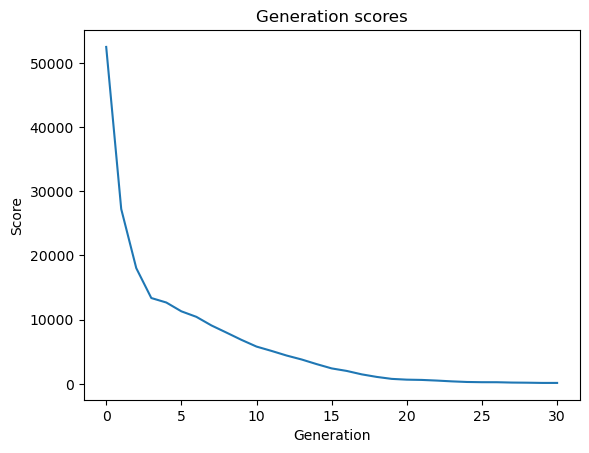

In [ ]:
# Wektor wyników w danej generacji
wyniki_danej_generacji = [gradePopulation(item,D) for item in epochs]

plt.plot(wyniki_danej_generacji)
plt.xlabel('Generation')
plt.ylabel('Score')
plt.title('Generation scores')
plt.show()